In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))  # add project root

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
plt.style.use("seaborn-v0_8-whitegrid")

#from pipelines.pipeline_runner import run_full_pipeline_with_split  
#from utils.ml_utils import prepare_X_y  

from pipelines.export_for_kaggle import export_for_kaggle  

from utils.stage3_utils import (
    fit_stage3,
    transform_stage3,
    prepare_X_y
)




## Pre-processing script

In [3]:
export_for_kaggle()

Exporting pre-processed data for Kaggle

[1/3] Running Stage 1 (Basic Cleaning)...


   ✓ Stage 1 complete: 22,306 rows, 71 columns

[2/3] Running Stage 2 (Plausibility & Outliers)...
   ✓ Stage 2 complete: 20,900 rows, 42 columns

[3/3] Running Stage 2.5 (Geo Enrichment)...
   ✓ Stage 2.5 complete: 21,472 rows, 59 columns

[SAVE] Writing to ../data/pre_processed/pre_processed_data_for_kaggle.csv...
   ✓ Saved successfully (9.55 MB)

EXPORT COMPLETE


,url,property_id,price,rooms,area,state,facades_number,is_furnished,has_terrace,has_garden,has_swimming_pool,has_equipped_kitchen,build_year,cellar,has_garage,kitchen_surface_house,bathrooms,heating_type,terrace_surface_apartment,land_surface_house,sewer_connection,running_water,primary_energy_consumption,co2_house,certification_electrical_installation,preemption_right,flooding_area_type,leased,living_room_surface,attic_house,glazing_type,elevator,entry_phone_apartment,access_disabled,apartement_floor_apartment,number_floors_apartment,toilets,cadastral_income_house,property_subtype,postal_code,locality,property_type,municipality_nl,municipality_fr,arrondissement_nl,arrondissement_fr,province_nl,province_fr,median_income,region,address,province,apt_avg_m2_province,house_avg_m2_province,apt_avg_m2_region,house_avg_m2_region,province_benchmark_m2,region_benchmark_m2,national_benchmark_m2
0,https://immovlan.be/en/detail/apartment/for-sa...,rbu69315,269000.00,1.00,51.00,-1,-1.00,0,1,0,-1,-1,1968.00,1,1,-1.00,1.00,-1,-1.00,-1.00,-1,-1,184.00,-1.00,-1,0,-1,-1,-1.00,-1.00,-1,-1.00,-1.00,-1,-1.00,-1.00,-1.00,-1.00,apartment,2600,berchem,Apartment,Antwerpen,Anvers,Arrondissement Antwerpen,Arrondissement d’Anvers,Provincie Antwerpen,Province d’Anvers,23.99,Flanders,Grote Steenweg 227 203 2600 Berchem,Provincie Antwerpen,2849,2419,3133,2266,2849,3133,3091
1,https://immovlan.be/en/detail/apartment/for-sa...,rbu69316,299000.00,2.00,79.00,2,2.00,0,1,0,-1,-1,2011.00,-1,1,-1.00,1.00,5,5.00,-1.00,-1,1,100.00,-1.00,1,1,1,0,22.00,-1.00,-1,1.00,-1.00,-1,2.00,-1.00,1.00,-1.00,apartment,2050,antwerp,Apartment,Antwerpen,Anvers,Arrondissement Antwerpen,Arrondissement d’Anvers,Provincie Antwerpen,Province d’Anvers,23.99,Flanders,Hugues C. Pernathlaan 22 203 2050 Antwerp,Provincie Antwerpen,2849,2419,3133,2266,2849,3133,3091
2,https://immovlan.be/en/detail/apartment/for-sa...,rbu68996,359000.00,3.00,110.00,-1,-1.00,0,1,0,-1,-1,-1.00,-1,1,-1.00,1.00,3,-1.00,-1.00,-1,1,-1.00,-1.00,-1,-1,-1,0,-1.00,-1.00,-1,0.00,-1.00,-1,2.00,-1.00,1.00,-1.00,apartment,2610,wilrijk,Apartment,Antwerpen,Anvers,Arrondissement Antwerpen,Arrondissement d’Anvers,Provincie Antwerpen,Province d’Anvers,23.99,Flanders,NaN,Provincie Antwerpen,2849,2419,3133,2266,2849,3133,3091
3,https://immovlan.be/en/detail/apartment/for-sa...,rbu69309,239000.00,2.00,84.00,2,2.00,0,1,0,-1,-1,1963.00,-1,-1,-1.00,1.00,3,-1.00,-1.00,-1,1,163.00,-1.00,0,1,-1,0,-1.00,-1.00,-1,1.00,-1.00,-1,5.00,-1.00,-1.00,-1.00,apartment,2060,antwerp,Apartment,Antwerpen,Anvers,Arrondissement Antwerpen,Arrondissement d’Anvers,Provincie Antwerpen,Province d’Anvers,23.99,Flanders,Kerkstraat 2 501 2060 Antwerp,Provincie Antwerpen,2849,2419,3133,2266,2849,3133,3091
4,https://immovlan.be/en/detail/apartment/for-sa...,rbu69307,189000.00,2.00,80.00,2,2.00,0,0,0,-1,-1,1930.00,-1,-1,-1.00,-1.00,-1,-1.00,-1.00,-1,-1,149.00,-1.00,1,0,1,0,-1.00,-1.00,-1,0.00,-1.00,-1,1.00,-1.00,-1.00,-1.00,apartment,2610,wilrijk,Apartment,Antwerpen,Anvers,Arrondissement Antwerpen,Arrondissement d’Anvers,Provincie Antwerpen,Province d’Anvers,23.99,Flanders,Golfstraat 7 101 2610 Wilrijk,Provincie Antwerpen,2849,2419,3133,2266,2849,3133,3091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21467,https://immovlan.be/en/detail/villa/for-sale/1...,rbt75700,1550000.00,10.00,538.00,-1,4.00,-1,0,0,-1,-1,-1.00,-1,1,-1.00,3.00,-1,-1.00,2711.00,-1,-1,-1.00,-1.00,-1,1,1,0,-1.00,1.00,-1,0.00,-1.00,0,-1.00,2.00,-1.00,-1.00,villa,1980,zemst,House,Zemst,Zemst,Arrondissement Halle-Vilvoorde,Arrondissement de Hal-Vilvorde,Provincie Vlaams-Brabant,Province du Brabant flamand,32.36,Flanders,Bosstraat 46 1980 Zemst,Provincie Vlaams-Brabant,3260,2539,3133,2266,2539,2266,2076
21468,https://immovlan.be/en/detail/villa/for-sale/1...,rbu23616,749000.00,5.00,245.00,2,4.00,-1,1,1,1,2,-1.00,

In [4]:
def evaluate_regression(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"===== {name} =====")
    print(f"MAE: {mae:,.2f}")
    print(f"R² : {r2:.4f}")
    return mae, r2


def plot_regression_diagnostics(y_true, y_pred, title_prefix="Model"):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1) Actual vs Predicted
    axes[0].scatter(y_true, y_pred, alpha=0.4)
    min_v = min(y_true.min(), y_pred.min())
    max_v = max(y_true.max(), y_pred.max())
    axes[0].plot([min_v, max_v], [min_v, max_v], "r--", linewidth=2)
    axes[0].set_title(f"{title_prefix} — Actual vs Predicted")
    axes[0].set_xlabel("Actual Price")
    axes[0].set_ylabel("Predicted Price")

    # 2) Residual Distribution
    sns.histplot(residuals, kde=True, bins=40, ax=axes[1], color="steelblue")
    axes[1].set_title(f"{title_prefix} — Residual Distribution")
    axes[1].set_xlabel("Residual (Actual - Predicted)")

    # 3) Residuals vs Predicted
    axes[2].scatter(y_pred, residuals, alpha=0.4)
    axes[2].axhline(0, color="red", linestyle="--", linewidth=2)
    axes[2].set_title(f"{title_prefix} — Residuals vs Predicted")
    axes[2].set_xlabel("Predicted Price")
    axes[2].set_ylabel("Residual")

    plt.tight_layout()
    plt.show()


def plot_lr_feature_importance(model, feature_names, top_n=20, title="LR Coefficients"):
    """
    model: fitted LinearRegression (from pipeline.named_steps["model"])
    feature_names: list/Index of feature names (X.columns)
    """
    coefs = model.coef_
    features = np.array(feature_names)

    idx = np.argsort(np.abs(coefs))[::-1][:top_n]
    top_features = features[idx]
    top_coefs = coefs[idx]

    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_coefs)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Coefficient value")
    plt.tight_layout()
    plt.show()


def plot_tree_importances(model, feature_names, top_n=30, title="Random Forest — Feature Importances"):
    importances = model.feature_importances_
    features = np.array(feature_names)
    idx = np.argsort(importances)[::-1][:top_n]
    top_features = features[idx]
    top_importances = importances[idx]

    plt.figure(figsize=(12, 10))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_importances)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


## Linear Regression

In [8]:
# ============================================================
# LINEAR REGRESSION — MATCHING XGB STRUCTURE EXACTLY (NO TEST FIT)
# ============================================================

from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# -------------------------------------------------------------------
# 1) Stage 3: Fit on TRAIN only
# -------------------------------------------------------------------
fitted_lr = fit_stage3(df_train)

df_train_s3_lr = transform_stage3(df_train, fitted_lr)
df_test_s3_lr  = transform_stage3(df_test,  fitted_lr)

# X, y from Stage 3
X_train_lr, y_train_lr = prepare_X_y(df_train_s3_lr)
X_test_lr,  y_test_lr  = prepare_X_y(df_test_s3_lr)  # unused, same as XGB

# -------------------------------------------------------------------
# 2) 5-Fold CV — identical structure to XGB
# -------------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
lr_scores = []

for train_idx, val_idx in kf.split(X_train_lr):

    X_tr = X_train_lr.iloc[train_idx]
    X_va = X_train_lr.iloc[val_idx]
    y_tr = y_train_lr.iloc[train_idx]
    y_va = y_train_lr.iloc[val_idx]

    # Imputation (manual, same as XGB)
    imputer = SimpleImputer(strategy="median")
    X_tr_imp = imputer.fit_transform(X_tr)
    X_va_imp = imputer.transform(X_va)

    # Linear Regression model
    model = LinearRegression()
    model.fit(X_tr_imp, y_tr)

    # ---- Train predictions
    preds_train = model.predict(X_tr_imp)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # ---- Validation predictions
    preds_val = model.predict(X_va_imp)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    lr_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"LR Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1

# -------------------------------------------------------------------
# 3) CV Summary — identical to XGB output
# -------------------------------------------------------------------
mean_r2_train = np.mean([s[0] for s in lr_scores])
mean_mae_train = np.mean([s[1] for s in lr_scores])
mean_r2_val   = np.mean([s[2] for s in lr_scores])
mean_mae_val  = np.mean([s[3] for s in lr_scores])

print("\n=== LINEAR REGRESSION 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


LR Fold 1 → Train R2: 0.61211 | Train MAE: 89446.38 || Val R2: 0.58412 | Val MAE: 90697.75
LR Fold 2 → Train R2: 0.61527 | Train MAE: 90203.51 || Val R2: 0.57010 | Val MAE: 90164.37
LR Fold 3 → Train R2: 0.61044 | Train MAE: 90858.82 || Val R2: 0.58906 | Val MAE: 88881.27
LR Fold 4 → Train R2: 0.59829 | Train MAE: 90483.99 || Val R2: 0.63995 | Val MAE: 89940.49
LR Fold 5 → Train R2: 0.60066 | Train MAE: 88739.30 || Val R2: 0.62750 | Val MAE: 92332.88

=== LINEAR REGRESSION 5-FOLD CV SUMMARY ===
Mean Train R2: 0.60735
Mean Train MAE: 89946.40
Mean Val   R2: 0.60215
Mean Val   MAE: 90403.35


## Random forrest

In [9]:
# ============================================================
# RANDOM FOREST — MATCHING XGB STRUCTURE EXACTLY (5-FOLD CV)
# ============================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# -------------------------------------------------------------------
# 1) Stage 3: Fit on TRAIN only (same logic as XGB)
# -------------------------------------------------------------------
fitted_rf = fit_stage3(df_train)

df_train_s3_rf = transform_stage3(df_train, fitted_rf)
df_test_s3_rf  = transform_stage3(df_test,  fitted_rf)  # unused, same as XGB

# Prepare X and y
X_train_rf, y_train_rf = prepare_X_y(df_train_s3_rf)
X_test_rf,  y_test_rf  = prepare_X_y(df_test_s3_rf)  # unused

# -------------------------------------------------------------------
# 2) 5-Fold CV (same loop structure as XGB)
# -------------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
rf_scores = []

for train_idx, val_idx in kf.split(X_train_rf):

    X_tr = X_train_rf.iloc[train_idx]
    X_va = X_train_rf.iloc[val_idx]
    y_tr = y_train_rf.iloc[train_idx]
    y_va = y_train_rf.iloc[val_idx]

    # Manual imputation (matching XGB and LR)
    imputer = SimpleImputer(strategy="median")
    X_tr_imp = imputer.fit_transform(X_tr)
    X_va_imp = imputer.transform(X_va)

    # Random Forest model
    model = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr_imp, y_tr)

    # ---- TRAIN predictions
    preds_train = model.predict(X_tr_imp)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # ---- VALIDATION predictions
    preds_val = model.predict(X_va_imp)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    rf_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"RF Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1

# -------------------------------------------------------------------
# 3) CV SUMMARY (identical to XGB output format)
# -------------------------------------------------------------------
mean_r2_train = np.mean([s[0] for s in rf_scores])
mean_mae_train = np.mean([s[1] for s in rf_scores])
mean_r2_val   = np.mean([s[2] for s in rf_scores])
mean_mae_val  = np.mean([s[3] for s in rf_scores])

print("\n=== RANDOM FOREST 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


RF Fold 1 → Train R2: 0.97559 | Train MAE: 18463.86 || Val R2: 0.81850 | Val MAE: 49825.74
RF Fold 2 → Train R2: 0.97536 | Train MAE: 18525.70 || Val R2: 0.82911 | Val MAE: 48194.83
RF Fold 3 → Train R2: 0.97506 | Train MAE: 18493.99 || Val R2: 0.82580 | Val MAE: 49326.83
RF Fold 4 → Train R2: 0.97518 | Train MAE: 18637.27 || Val R2: 0.83913 | Val MAE: 48919.69
RF Fold 5 → Train R2: 0.97501 | Train MAE: 18361.59 || Val R2: 0.82213 | Val MAE: 50918.90

=== RANDOM FOREST 5-FOLD CV SUMMARY ===
Mean Train R2: 0.97524
Mean Train MAE: 18496.48
Mean Val   R2: 0.82693
Mean Val   MAE: 49437.20


## Optuna Tuning for XGBOOST and CATBOOST

Multiple Optuna tuning iterations were explored for both XGBoost and CatBoost. The most up-to-date implementation can be found in utils/optuna_tuning_v5.
All experiments were executed on a Kaggle P10 GPU runtime, with both models configured to leverage GPU-accelerated training for faster and more efficient hyperparameter optimization.

## XGBOOST

In [6]:
#Non-conservative params with new utils script
# 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

# ========================================
# CONFIG
# ========================================
DATA_PATH = "../data/pre_processed/pre_processed_data_for_kaggle.csv"
TEST_SIZE = 0.15
RANDOM_STATE = 42
N_TRIALS = 200      
EARLY_STOPPING_ROUNDS = 50
TARGET_ENCODING_ALPHA = 100.0
# ========================================
# 1) Load raw data
df = pd.read_csv(DATA_PATH)

# 2) Split BEFORE Stage 3
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# 3) Fit Stage 3 ONLY on training
fitted = fit_stage3(df_train)

# 4) Transform BOTH datasets using training stats
df_train_s3 = transform_stage3(df_train, fitted)
df_test_s3  = transform_stage3(df_test, fitted)

# 5) Final X and y
X_train, y_train = prepare_X_y(df_train_s3)
X_test,  y_test  = prepare_X_y(df_test_s3)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
xgb_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = XGBRegressor(
        n_estimators=1831,
        max_depth=6,
        learning_rate=0.08432907918641791,
        subsample=0.820021614087313,
        colsample_bytree=0.7915458860746174,
        min_child_weight=6,
        reg_alpha=1.8035294814526148,
        reg_lambda=0.6286950749255498,
        gamma=0.4559760318732715,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr)

    # Train predictions
    preds_train = model.predict(X_tr)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # Validation predictions
    preds_val = model.predict(X_va)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    xgb_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"XGB Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1


# Summary
mean_r2_train = np.mean([s[0] for s in xgb_scores])
mean_mae_train = np.mean([s[1] for s in xgb_scores])
mean_r2_val   = np.mean([s[2] for s in xgb_scores])
mean_mae_val  = np.mean([s[3] for s in xgb_scores])

print("\n=== XGBOOST 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


XGB Fold 1 → Train R2: 0.99769 | Train MAE: 8173.07 || Val R2: 0.86943 | Val MAE: 44169.64
XGB Fold 2 → Train R2: 0.99757 | Train MAE: 8476.99 || Val R2: 0.86556 | Val MAE: 43559.39
XGB Fold 3 → Train R2: 0.99799 | Train MAE: 7894.26 || Val R2: 0.85444 | Val MAE: 44092.64
XGB Fold 4 → Train R2: 0.99802 | Train MAE: 7778.07 || Val R2: 0.86111 | Val MAE: 45260.53
XGB Fold 5 → Train R2: 0.99761 | Train MAE: 8403.82 || Val R2: 0.85849 | Val MAE: 45470.04

=== XGBOOST 5-FOLD CV SUMMARY ===
Mean Train R2: 0.99778
Mean Train MAE: 8145.24
Mean Val   R2: 0.86180
Mean Val   MAE: 44510.45


## Catboost

In [14]:
# ============================================================
# CATBOOST — Preprocessing identical to XGBOOST pipeline
# ============================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor


# ========================================
# CONFIG
# ========================================
DATA_PATH = "../data/pre_processed/pre_processed_data_for_kaggle.csv"
TEST_SIZE = 0.15
RANDOM_STATE = 42

# ========================================
# 1) Load data
# ========================================
df = pd.read_csv(DATA_PATH)

# ========================================
# 2) Split BEFORE Stage 3
# ========================================
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# ========================================
# 3) FIT Stage 3 only on training
# ========================================
fitted = fit_stage3(df_train)

# ========================================
# 4) TRANSFORM train + test using training statistics
# ========================================
df_train_s3 = transform_stage3(df_train, fitted)
df_test_s3  = transform_stage3(df_test, fitted)

# ========================================
# 5) Final X and y
# ========================================
X_train, y_train = prepare_X_y(df_train_s3)
X_test,  y_test  = prepare_X_y(df_test_s3)

# ========================================
# 6) KFold CV for CatBoost
# ========================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
cat_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = CatBoostRegressor(
        iterations=1369,
        depth=9,
        learning_rate=0.12920462180825767,
        l2_leaf_reg=0.8242326515788326,
        random_strength=2.2847008203805235,
        bagging_temperature=1.1151326396033874,
        border_count=166,
        loss_function="RMSE",
        random_state=42,
        verbose=False,
        task_type="CPU"
    )


    model.fit(X_tr, y_tr)

    # Train metrics
    preds_train = model.predict(X_tr)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # Validation metrics
    preds_val = model.predict(X_va)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    cat_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"CAT Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1

# ========================================
# 7) Summary
# ========================================
mean_r2_train = np.mean([s[0] for s in cat_scores])
mean_mae_train = np.mean([s[1] for s in cat_scores])
mean_r2_val   = np.mean([s[2] for s in cat_scores])
mean_mae_val  = np.mean([s[3] for s in cat_scores])

print("\n=== CATBOOST 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


CAT Fold 1 → Train R2: 0.99870 | Train MAE: 6294.77 || Val R2: 0.83843 | Val MAE: 43644.57
CAT Fold 2 → Train R2: 0.99876 | Train MAE: 6114.37 || Val R2: 0.86308 | Val MAE: 42230.89
CAT Fold 3 → Train R2: 0.99887 | Train MAE: 5959.70 || Val R2: 0.86101 | Val MAE: 42650.01
CAT Fold 4 → Train R2: 0.99880 | Train MAE: 6131.31 || Val R2: 0.85179 | Val MAE: 44511.73
CAT Fold 5 → Train R2: 0.99876 | Train MAE: 6146.43 || Val R2: 0.84960 | Val MAE: 45478.31

=== CATBOOST 5-FOLD CV SUMMARY ===
Mean Train R2: 0.99878
Mean Train MAE: 6129.32
Mean Val   R2: 0.85278
Mean Val   MAE: 43703.10


## Reducing the features

In [21]:
import pandas as pd
import numpy as np
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
plt.style.use("seaborn-v0_8-whitegrid")

feature_importances = model_all_features.get_feature_importance()
feature_names = X_train.columns

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances
}).sort_values("importance", ascending=False)

print(fi_df.to_string())



                                          feature  importance
1                                            area       16.48
71                           postal_code_te_price        8.84
72                              locality_te_price        8.06
13                                      bathrooms        6.91
0                                           rooms        5.82
15                      terrace_surface_apartment        4.32
19                     primary_energy_consumption        4.17
2                                           state        3.28
16                             land_surface_house        2.85
41                          province_benchmark_m2        2.85
35                                    postal_code        2.70
42                            region_benchmark_m2        2.25
69                      property_subtype_te_price        2.12
39                              apt_avg_m2_region        1.71
33                                        toilets        1.59
34      

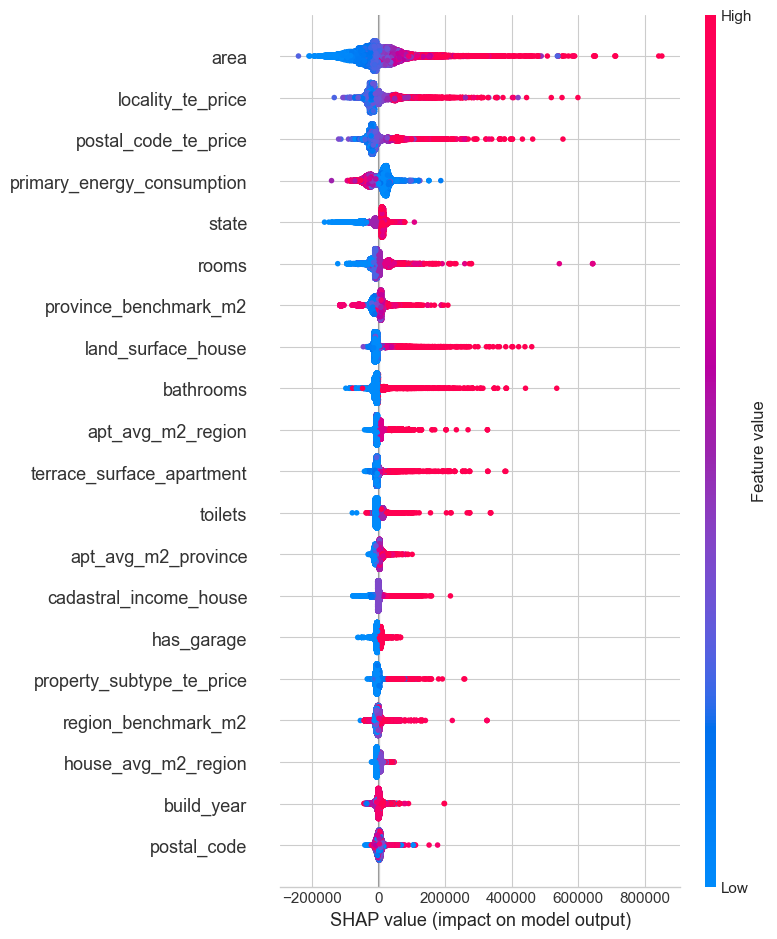

In [7]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


In [8]:
shap_importance = np.abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    "feature": X_train.columns,
    "shap_importance": shap_importance
}).sort_values("shap_importance", ascending=False)

print(shap_df.head(30))


                       feature  shap_importance
1                         area         57254.73
72           locality_te_price         27641.22
71        postal_code_te_price         26600.68
19  primary_energy_consumption         22695.76
2                        state         19180.08
0                        rooms         17062.54
41       province_benchmark_m2         15293.22
16          land_surface_house         14667.57
13                   bathrooms         13062.48
39           apt_avg_m2_region         12246.22
15   terrace_surface_apartment          8766.61
33                     toilets          8446.29
37         apt_avg_m2_province          8014.11
34      cadastral_income_house          7280.75
11                  has_garage          7004.12
69   property_subtype_te_price          6978.56
42         region_benchmark_m2          6732.49
40         house_avg_m2_region          6392.76
9                   build_year          6071.66
35                 postal_code          

## Retrain with reduced features

In [23]:
# ============================================================
# REDUCED-FEATURE CATBOOST (32 FEATURES)
# ============================================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor


# ========================================
# CONFIG
# ========================================
DATA_PATH = "../data/pre_processed/pre_processed_data_for_kaggle.csv"
TEST_SIZE = 0.15
RANDOM_STATE = 42

# Updated list
REDUCED_FEATURES = [
    "area",
    "postal_code_te_price",
    "locality_te_price",
    "bathrooms",
    "rooms",
    "terrace_surface_apartment",
    "primary_energy_consumption",
    "state",
    "land_surface_house",
    "province_benchmark_m2",
    "postal_code",
    "region_benchmark_m2",
    "property_subtype_te_price",
    "apt_avg_m2_region",
    "toilets",
    "cadastral_income_house",
    "living_room_surface",
    "property_type_te_price",
    "median_income",
    "apartement_floor_apartment",
    "build_year",
    "number_floors_apartment",
    "house_avg_m2_province",
    "entry_phone_apartment",
    "has_garage",
    "apt_avg_m2_province",
    "has_garden",
    "elevator",
    "has_terrace",
    "facades_number",
    "has_swimming_pool",
    "house_avg_m2_region",
    "has_equipped_kitchen",
]



# ========================================
# 1) Load data
# ========================================
df = pd.read_csv(DATA_PATH)

# ========================================
# 2) Split BEFORE Stage 3 (to avoid leakage)
# ========================================
df_train, df_test = train_test_split(
    df, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# ========================================
# 3) FIT Stage 3 only on training
# ========================================
fitted = fit_stage3(df_train)

# ========================================
# 4) TRANSFORM train + test using training statistics
# ========================================
df_train_s3 = transform_stage3(df_train, fitted)
df_test_s3  = transform_stage3(df_test, fitted)

# ========================================
# 5) Prepare X and y
# ========================================
X_train_full, y_train = prepare_X_y(df_train_s3)
X_test_full,  y_test  = prepare_X_y(df_test_s3)

# Select only your 12 features
X_train = X_train_full[REDUCED_FEATURES].copy()
X_test  = X_test_full[REDUCED_FEATURES].copy()


# ========================================
# 6) KFold CV for CatBoost
# ========================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
cat_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = CatBoostRegressor(
        iterations=1369,
        depth=9,
        learning_rate=0.12920462180825767,
        l2_leaf_reg=0.8242326515788326,
        random_strength=2.2847008203805235,
        bagging_temperature=1.1151326396033874,
        border_count=166,
        loss_function="RMSE",
        random_state=42,
        verbose=False,
        task_type="CPU"
    )

    model.fit(X_tr, y_tr)

    # Train metrics
    preds_train = model.predict(X_tr)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # Validation metrics
    preds_val = model.predict(X_va)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    cat_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"CAT Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1


# ========================================
# 7) Summary
# ========================================
mean_r2_train = np.mean([s[0] for s in cat_scores])
mean_mae_train = np.mean([s[1] for s in cat_scores])
mean_r2_val   = np.mean([s[2] for s in cat_scores])
mean_mae_val  = np.mean([s[3] for s in cat_scores])

print("\n=== CATBOOST REDUCED FEATURES — 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:,.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:,.2f}")


CAT Fold 1 → Train R2: 0.99790 | Train MAE: 7878.55 || Val R2: 0.83511 | Val MAE: 44210.16
CAT Fold 2 → Train R2: 0.99795 | Train MAE: 7908.15 || Val R2: 0.86418 | Val MAE: 43693.88
CAT Fold 3 → Train R2: 0.99812 | Train MAE: 7708.36 || Val R2: 0.85401 | Val MAE: 44488.49
CAT Fold 4 → Train R2: 0.99807 | Train MAE: 7720.28 || Val R2: 0.84770 | Val MAE: 45077.77
CAT Fold 5 → Train R2: 0.99800 | Train MAE: 7823.91 || Val R2: 0.85128 | Val MAE: 46235.40

=== CATBOOST REDUCED FEATURES — 5-FOLD CV SUMMARY ===
Mean Train R2: 0.99801
Mean Train MAE: 7,807.85
Mean Val   R2: 0.85046
Mean Val   MAE: 44,741.14
